# Develop a Fake or Real Discriminator

In this notebook, we walk through the steps of developing a machine learning model that is trained to distinguish between fake (=synthetic) and real records. The model's ability to correctly discriminate between these on an unseen holdout can serve us as another helpful quality criteria for the generated synthetic data. The more realistic those synthetic records are, the harder it will be for any discriminator to tell these apart from the real records.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/fake-or-real/fake-or-real.png' width="400px"/>

In order to make the analysis more interesting, we intentionally create synthetic data of lower quality, by limiting the training samples to only a thousand records. Otherwise, the discriminator would not be able to find much signal, if the synthesizer, like MOSTLY AI, is of very high quality.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, which consists of 48,842 records across 15 attributes.

We will use the MOSTLY AI Synthetic Data Platform to create a Generator and then use that Generator to create a Synthetic dataset.

Please replace INSERT_YOUR_API_KEY with your API KEY before executing the code below and make sure you have all the required packages installed.

In [18]:
#!pip install mostlyai scikit-learn seaborn lightgbm

from mostlyai import MostlyAI
import pandas as pd

# fetch original data
df_tgt = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz')
df_tgt

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [4]:
# initialize client
mostly = MostlyAI(
    api_key='INSERT_YOUR_API_KEY' 
)

# create generator with a sample of 1,000
g = mostly.train(data=df_tgt.sample(1_000), name="Fake vs. Real Tutorial - Census Data")

# Generate synthetic data
syn = mostly.generate(g, size=48_842).data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created synthetic dataset ]8;id=357370;https://app.mostly.ai/d/synthetic-datasets/14123022-5d83-4bf0-9a7a-b06b7514d4c4\14123022-5d83-4bf0-9a7a-b06b7514d4c4]8;;\ with generator ]8;id=831359;https://app.mostly.ai/d/generators/e7d72978-207d-4b44-ba34-597ed5dc9578\e7d72978-207d-4b44-ba34-597ed5dc9578]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic data with 48,842 records and 15 attributes


## Train Discriminator

In [19]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split

def prepare_xy(df, target_col, target_val):
    # split target variable `y`
    y = (df[target_col]==target_val).astype(int)
    # convert strings to categoricals, and all others to floats
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        },
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

import warnings
warnings.filterwarnings('ignore')

In [20]:
# concatenate FAKE and REAL data together
df = pd.concat([
    df_tgt.assign(split='REAL'),
    syn.assign(split='FAKE'),
], axis=0)
df.insert(0, 'split', df.pop('split'))
df.groupby('split').size()

split
FAKE    48842
REAL    48842
dtype: int64

In [21]:
# take a 20% holdout dataset aside for evaluation
trn, hol = train_test_split(df, test_size=0.2, random_state=1)

In [22]:
# train the discriminator on the remaining 80% training dataset
X_trn, y_trn = prepare_xy(trn, 'split', 'FAKE')
model = train_model(X_trn, y_trn)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.973894


In [23]:
# score the model on the holdout dataset, assigning a probability to each record on whether it's FAKE or REAL
X_hol, y_hol = prepare_xy(hol, 'split', 'FAKE')
hol.insert(1, 'is_fake', model.predict(X_hol).round(4))

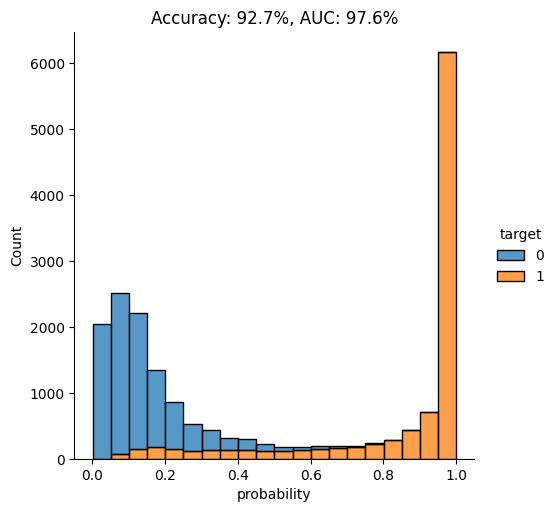

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

auc = roc_auc_score(y_hol, hol.is_fake)
acc = accuracy_score(y_hol, (hol.is_fake>0.5).astype(int))
probs_df = pd.concat([
    pd.Series(hol.is_fake, name='probability').reset_index(drop=True),
    pd.Series(y_hol, name='target').reset_index(drop=True)
], axis=1)
fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, multiple="stack")
fig = plt.title(f"Accuracy: {acc:.1%}, AUC: {auc:.1%}")
plt.show()

As you can see from above chart, the discriminator has learned to pick up some signals that allow it with a varying level of confidence to determine whether a record is FAKE or REAL. 

The AUC can be interpreted as the percentage of cases, where the discriminator is able to correctly spot the FAKE record, given a set of a FAKE and a REAL record.

#### Sample records, that seem very FAKE

In [25]:
hol.sort_values('is_fake').tail(n=100).sample(n=5)

,split,is_fake,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
14087,FAKE,0.9998,19.0,Private,276634.0,11th,14.0,Divorced,Prof-specialty,Wife,White,Female,0.0,0.0,45.0,United-States,>50K
35488,FAKE,0.9998,17.0,Private,182830.0,Bachelors,2.0,Divorced,Other-service,Not-in-family,White,Female,0.0,0.0,35.0,United-States,<=50K
19754,FAKE,0.9998,18.0,Self-emp-not-inc,109155.0,Some-college,16.0,Never-married,Transport-moving,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
41403,FAKE,0.9998,18.0,Private,234139.0,7th-8th,14.0,Never-married,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
30122,FAKE,0.9998,36.0,?,212495.0,HS-grad,16.0,Divorced,Sales,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K


In these cases, it is the mismatch between `education` and `education_num` that gives away the fact that these are FAKE. E.g., in the original data, education level `Assoc-acdm` was mapped to education number 12, whereas in the synthetic data we see various other numeric values.

In [26]:
pd.crosstab(tgt.education, tgt.education_num)

education_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1389,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1812,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,657,0,0,0,0,0,0,0,0
1st-4th,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,509,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,955,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,756,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1601,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,2061,0,0,0,0,0


In [10]:
pd.crosstab(syn.education, syn.education_num)

education_num,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,
10th,74,40,15,16,1041,51,72,53,2,0,1,0,1,0,1
11th,25,3,45,91,45,1909,119,19,0,0,0,0,0,0,0
12th,89,13,64,73,164,152,135,6,0,0,4,0,2,0,3
5th-6th,4,269,39,23,24,19,6,106,0,0,0,12,2,0,4
7th-8th,75,41,237,96,87,133,52,23,0,1,11,3,18,3,6
9th,43,22,63,104,62,86,28,2,0,1,4,1,1,3,4
Assoc-acdm,5,5,6,3,3,2,4,0,6,298,528,9,346,182,213
Assoc-voc,1,0,0,0,0,0,0,0,91,1188,269,2,114,33,180
Bachelors,0,1,0,0,0,0,0,0,9,1,1,8039,23,2,0


#### Sample records, that seem very REAL

I.e. these are type of records, that the synthesizer has apparently failed to create. Thus, as they are then absent from the synthetic data, the discriminator recognizes these as REAL.

In [27]:
hol.sort_values('is_fake').head(n=100).sample(n=5)

,split,is_fake,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
5870,REAL,0.0023,51.0,Private,320513.0,7th-8th,4.0,Married-spouse-absent,Craft-repair,Not-in-family,Black,Male,0.0,0.0,50.0,Dominican-Republic,<=50K
37290,REAL,0.0029,50.0,Private,176773.0,Preschool,1.0,Married-civ-spouse,Farming-fishing,Husband,Black,Male,0.0,0.0,40.0,Haiti,<=50K
6337,REAL,0.0030,46.0,Private,377401.0,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,1902.0,70.0,Canada,>50K
19002,REAL,0.0024,47.0,Private,323798.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024.0,0.0,55.0,United-States,>50K
28652,REAL,0.0031,50.0,Self-emp-not-inc,42402.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2415.0,30.0,United-States,>50K


## Conclusion

This tutorial has shown how to train a discriminator that is set out to distinguish between FAKE and REAL records. The better the quality of the generated synthetic data, the less likely the discriminator (as well as we humans) can tell them apart.

## Further exercises

In addition to walking through the above instructions, we suggest..
* measuring the Discriminator's AUC if more training samples are used
* using a different dataset, eg. the UCI bank-marketing dataset [[2](#refs)]
* using a different ML model for the discriminator, eg. a RandomForest model [[3](#refs)]
* using a different synthesizer, eg. SynthCity, SDV, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://archive.ics.uci.edu/ml/datasets/bank+marketing
1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html